In [757]:
%env OMP_NUM_THREADS=2

env: OMP_NUM_THREADS=2


## Data loading
After downloading data, we can see that we have about 20k genes, and a total of five possible labels.
To make data easier to process, the total amount of samples has been limited to 400.

In [758]:
# Datasets can be downloaded here:
# https://perso.univ-rennes1.fr/valerie.monbet/MachineLearning/TCGA-PANCAN-HiSeq-801df20531/data.csv
# https://perso.univ-rennes1.fr/valerie.monbet/MachineLearning/TCGA-PANCAN-HiSeq-801df20531/labels.csv
from re import L
import pandas as pd
import numpy as np
from time import time

# Random sampling
nlinesfile = 802
nlinesrandomsample = 800
lines2skip = np.random.choice(np.arange(1,nlinesfile+1), (nlinesfile-nlinesrandomsample), replace=False)
df = pd.read_csv('data.csv', skiprows=lines2skip)
labels = pd.read_csv('labels.csv', skiprows=lines2skip)

print('Number of columns :', df.shape[1])
print('Number of rows :', df.shape[0])
df = df.merge(labels, on='Unnamed: 0') # Merging labels and features on index

# Dropping eventual NAs
df = df.dropna(axis=1)

Number of columns : 20532
Number of rows : 799


In [759]:
#dropping now useless index
df = df.drop('Unnamed: 0', axis=1)

# Converting all values to float to allow for numerical computations
sample_class = df['Class']
df_values = df.drop('Class', axis='columns')
df_values = df_values.astype(float)

# Dropping constant columns
df_values = df_values[df_values.std(axis='columns') > 1e-8]
df = pd.concat([df_values, sample_class], axis=1)
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


## Clustering using k-means algorithm

In [760]:
from sklearn.cluster import  KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import mixture
import matplotlib.pyplot as plt

Let us first define a function to compute the kmeans algorithm. This takes in a dataframe object containing all features (X) and a 'Class' column containing the ground truth (Y). \
It will apply the kmeans algorithm, and associate each predicted group to the most represented label within.

In [761]:
def compute_kmeans(data, n_clusters):
    n_clusters = int(data["Class"].nunique())
    k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    ground_truth = data["Class"]
    data.drop("Class", axis=1, inplace=True)
    k_means.fit(data)
    cl = k_means.labels_ # predicted classes 

    data['group'] = cl.tolist()
    data['Class'] = ground_truth
    data['pred_class'] = data['Class']

    # Assigning the most frequent class to each cluster
    for k in range(n_clusters):
        labels = data[['group', 'Class']]
        labels = labels[labels['group'] == k]
        label = labels['Class'].value_counts().index[0]
        data.loc[data['group'] == k, 'pred_class'] = label
    return data

Now we can apply our function to our full dataset, with all 20k+ gene expression as features. \
Then, we draw our confusion matrix in order to evaluate how well clusterization worked using the kmeans algorithm. 
* Note how much computing time this took: about a few seconds.

In [762]:
n_clusters = int(df["Class"].nunique())
start = time()
df = compute_kmeans(df, n_clusters)
end = time()
time_kmeans_all_features = end - start
print("Time taken to run KMeans: ", end - start)
print(df[['group', 'pred_class', 'Class']])


Time taken to run KMeans:  3.760075569152832
     group pred_class Class
0        1       PRAD  PRAD
1        3       LUAD  LUAD
2        1       PRAD  PRAD
3        1       PRAD  PRAD
4        0       BRCA  BRCA
..     ...        ...   ...
794      0       BRCA  BRCA
795      3       LUAD  LUAD
796      3       LUAD  COAD
797      1       PRAD  PRAD
798      1       PRAD  PRAD

[799 rows x 3 columns]


In [763]:
# Draw the confusion matrix
conf_mat =  confusion_matrix(df["Class"], df["pred_class"])
print("Confusion Matrix:")
print("   Line : Class. Column = Predicted Class\n")
print(conf_mat)

Confusion Matrix:
   Line : Class. Column = Predicted Class

[[300   0   0   0   0]
 [  0  77   0   1   0]
 [  1   0 144   0   0]
 [  2   0   0 138   0]
 [  0   0   0   0 136]]


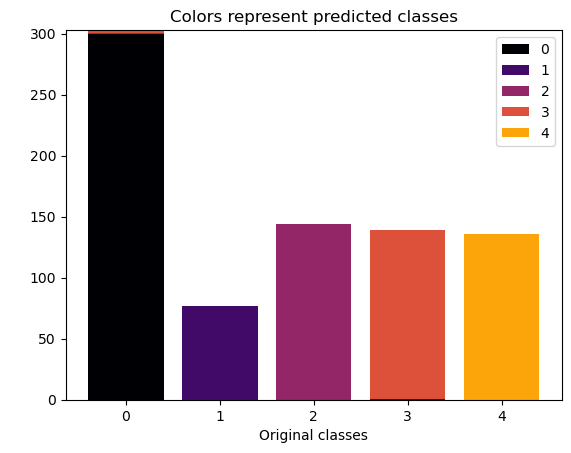

In [764]:
def BarPlotMat(M): 
# Fait un barplot pour chaque colonne de M.
# La couleur correspond à l'indice, la hauteur à la valeur
  I=M.shape[0]
  J=M.shape[1]
  ind = np.arange(J)
  plots = []
  height_cumul = 0
  for i in range(I):
    color = plt.cm.inferno(i/I, 1)
    if k == 0:
      p = plt.bar(ind,M[i,:],width=.35, color=color)
    else:
      p = plt.bar(ind,M[i,:], bottom=height_cumul, color=color)
    height_cumul +=M[i,:]
    plots.append(p)    

BarPlotMat(conf_mat)
plt.xlabel('Original classes')
plt.ylabel(' ')
plt.title('Colors represent predicted classes')
plt.legend(['0','1','2','3','4',])

The classification is quite good, with a nice separation of the groups. It should be noted that if the separation wasn't so clear-cut, assigning a class to each group according to the predominant label name would be much more complicated. For instance, if two groups determined by kmeans contain a proportion close to two (or more!) labels, how can we reliably assign the right label to that group?

## Using PCA in conjunction with k-means
Since we only have 20k+ features and 400 samples, k-means computation time is within reason (only a couple seconds !). However, larger datasets may require dimension reduction techniques in order to reach a feasible computation time.
In the following section, we're going to explore how a dimension reduction method (PCA) can be used in conjunction with clusterization algorithms in order to make computation more efficient while conserving a meaningful result.

In [765]:
# Importing libraries
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold

In [766]:
# Standardizing the features
features = df_values # df_values is the raw number dataframe without the labels ie. all features.
features = StandardScaler().fit_transform(features)
labels = df['Class'].values

Applying PCA and calculating the first n=50 Principal Components.

*n=50 has been chosen due to the increasing computing time of the following kmeans. See below.*

In [767]:
# Calculating n=50 PCA components
n_components = 50
pca = PCA(n_components=n_components)
PC = pca.fit_transform(features)
df_pca = pd.DataFrame(data = PC,
    columns = [f'PC{i}' for i in range(1,n_components+1)])
df_pca = pd.concat([df_pca, df[['Class']]], axis = 1)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,Class
0,-57.891373,95.023101,74.226314,-12.297933,7.337781,36.232394,-7.495715,20.040374,0.069412,3.017646,...,0.749959,-0.658228,-6.315404,-0.168626,1.846555,3.897292,4.378922,-15.233861,-8.348815,PRAD
1,-16.855787,0.581949,-64.045487,-1.935759,-25.859533,27.457102,-16.004256,-17.109254,-21.938484,-27.942827,...,-11.352918,-0.366047,14.223113,-8.638003,-4.047830,-8.894656,9.584870,-21.600207,7.412611,LUAD
2,-70.114758,-19.911897,20.630310,47.710670,24.431449,17.895717,21.142540,-47.396217,-28.712396,-12.880356,...,-3.924251,-4.386723,6.131221,16.419206,-4.873967,-0.492822,17.691211,-7.278192,7.517300,PRAD
3,-48.904966,-9.562213,61.309988,37.629251,0.864413,23.321957,-4.566004,-21.523907,-15.334652,-12.871342,...,-7.585614,1.991912,-7.548746,5.950506,1.533455,-0.760351,-5.435154,-1.084829,-1.996253,PRAD
4,-17.526806,-51.408694,16.678018,-17.990024,26.061284,-1.265691,-6.293951,12.312545,-4.238785,28.835617,...,-2.252236,0.960575,-9.008683,-3.545670,6.532205,6.252697,-1.982580,1.787484,-2.355597,BRCA


Now let's see how much variance those 50 components explain :

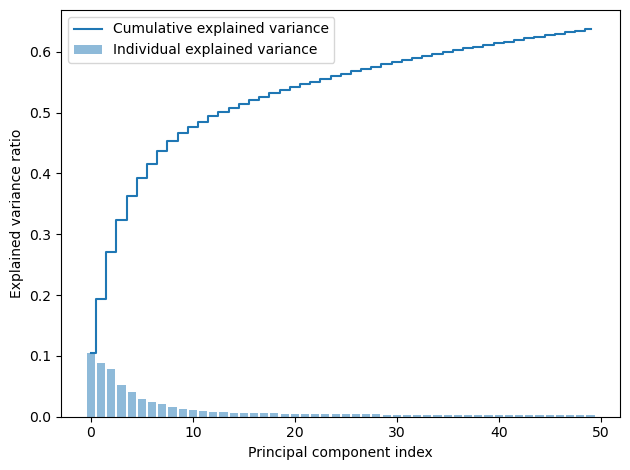

In [768]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


As can be seen on the above graph, the increment of variance percentage explained by adding principal components (PC) follows a diminishing return pattern.

Since those PCs represent a certain percentage of the variation between the samples, by using only a certain number of principal components, we're able to greatly reduce the amount of computation required while preserving part of the information.

We will now compute two clustering algorithms: kmeans and GMM on those PCs, and see how computation time (and results !) are affected.

## Computing kmeans on principal components
Measuring how much computing time is affected by dimension reduction is pretty easy: you just have to time the time it takes to cluster the data.
Comparing our confusion matrices will be done by using the accuracy metric, which is basically the number of rightly classified samples divided by the sum of all samples.

First, let's see how much accuracy our kmeans obtains without dimension reduction.

In [769]:
# Accuracy of kmeans on all non-reduced features
accuracy_score(df["Class"], df["pred_class"])

0.9949937421777222

We obtain a very high accuracy, almost a perfect score ! \
Now let's check accuracy depending on how much principal components are used :

In [770]:
# Calculate exec time and accuracy with different component numbers.
import statistics

timer, acc = [[] for _ in range(50)], [[] for _ in range(50)]

for _ in range(25):
    for i in range(1, 50):
        temp_df = df_pca.iloc[:, :i].copy()
        temp_df['Class'] = df_pca['Class']
        start = time()
        temp_df = compute_kmeans(temp_df, n_clusters)
        end = time()
        run_time = end - start
        conf_mat =  confusion_matrix(temp_df["Class"], temp_df["pred_class"])
        accuracy_score(temp_df["Class"], temp_df["pred_class"])
        timer[i].append(run_time)
        acc[i].append(accuracy_score(temp_df["Class"], temp_df["pred_class"]))
med_timer, med_acc = [], []
for i in range(0,len(timer)):
    try:
        med_timer.append(statistics.median(timer[i]))
        med_acc.append(statistics.median(acc[i]))
    except:
        continue

Text(0, 0.5, 'Median Accuracy')

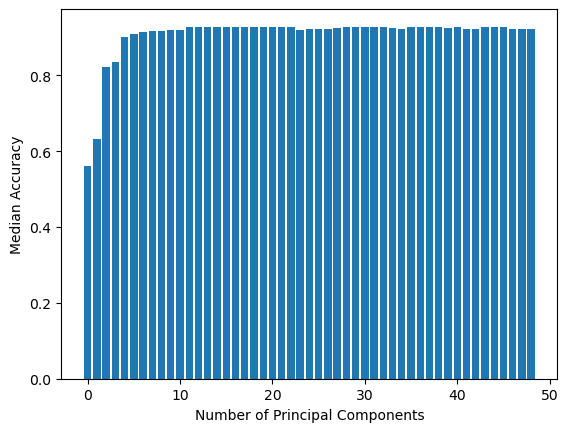

In [771]:
# Accuracy of the kmeans algorithm with different number of principal components.
plt.bar(range(len(med_acc)), med_acc)
plt.xlabel('Number of Principal Components')
plt.ylabel('Median Accuracy')

Text(0, 0.5, 'Median Execution Time')

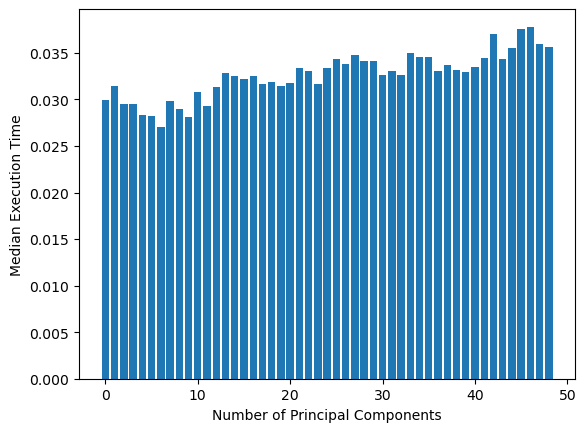

In [772]:
# Execution time of the kmeans algorithm with different number of principal components.
plt.bar(range(len(med_timer)), med_timer)
plt.xlabel('Number of Principal Components')
plt.ylabel('Median Execution Time')


*For each number of principal components, kmeans has been computed n=25 times. Considering the volatility of execution times values at this timescale, the median has been preferred over the average.*

As expected, execution time increases proportionally to the number of PC utilized. \
Accuracy increases as more PCs are added, and knowing that the first PCs are the most informative, it is not unexpected to see accuracy increase slowing after the first 10 PCs. \
n=10 PCs seems like a good cutoff. To put things into perspective, let's compare a kmeans with the full features included, and a kmeans on the first 10 PCs of a PCA:

<AxesSubplot:>

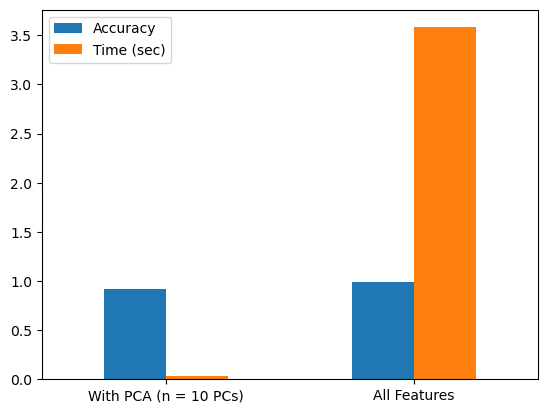

In [773]:
#Comparing accuracies of KMeans with all features and KMeans with n=10 PCA components.
pd.DataFrame({'Accuracy': [med_acc[10], 0.9924906132665833], 'Time (sec)': [med_timer[10], 3.5822019577026367]}, index=['With PCA (n = 10 PCs)', 'All Features']).plot.bar(rot=0)

As we can see while accuracy does not drop by a huge margin (delta = 0.07), the execution time reduces *very* significantly (~120x).

## Computing GMM on principal components

In [774]:
# Defining a function to compute GMM.

from sklearn.mixture import GaussianMixture

def compute_gmm(data, n_clusters):
    bic = []
    greatest_bic = -np.infty
    cv_types = ['spherical', 'tied', 'diag', 'full']
    ground_truth = data["Class"]
    data.drop("Class", axis=1, inplace=True)
    for cv_type in cv_types:
        gmm = GaussianMixture(n_components=n_clusters, random_state=0, covariance_type=cv_type).fit(data)
        bic.append(gmm.bic(data))
        if bic[-1] > greatest_bic:
            greatest_bic = bic[-1]
            best_gmm = gmm
    cl = best_gmm.predict(data) # predicted classes 
    data['group'] = cl.tolist()
    data['Class'] = ground_truth
    data['pred_class'] = data['Class']
    return data

What about another clustering method ? Gaussian Mixture Model is an iterative approach to clusterization, allowing more flexibility by handling non-spherical shapes of data clusterization. \
However, this comes with a computationnal cost. \
The computationnal cost increases a lot the more features we add.
As i found by trying to run the following cell (don't), RAM quickly becomes saturated.

Altough we have no point of reference when it comes to raw performance, GMM can still be compared to the kmeans algorithm by preprocessing the dataset through dimension reduction (here by PCA).

In [775]:
# Do not run this.

# df.drop(["pred_class", "group"], axis=1, inplace=True)
# start = time()
# df_tmp = compute_gmm(df, n_clusters)
# end = time()

# # Assigning the most frequent class to each cluster
# for k in range(n_clusters):
#     labels = df_tmp[['group', 'Class']]
#     labels = labels[labels['group'] == k]
#     label = labels['Class'].value_counts().index[0]
#     df_tmp.loc[df_tmp['group'] == k, 'pred_class'] = label

# run_time = end - start
# conf_mat =  confusion_matrix(df_tmp["Class"], df_tmp["pred_class"])

In [776]:
# GMM computation
timer, acc = [[] for _ in range(50)], [[] for _ in range(50)]

for _ in range(25):
    for i in range(1, 50):
        df_tmp = df_pca.iloc[:, :i].copy()
        df_tmp['Class'] = df_pca['Class']
        start = time()
        df_tmp = compute_gmm(df_tmp, n_clusters)
        end = time()

        # Assigning the most frequent class to each cluster
        for k in range(n_clusters):
            labels = df_tmp[['group', 'Class']]
            labels = labels[labels['group'] == k]
            label = labels['Class'].value_counts().index[0]
            df_tmp.loc[df_tmp['group'] == k, 'pred_class'] = label

        run_time = end - start
        conf_mat =  confusion_matrix(df_tmp["Class"], df_tmp["pred_class"])
        timer[i].append(run_time)
        acc[i].append(accuracy_score(df_tmp["Class"], df_tmp["pred_class"]))
        df_tmp.drop(['group', 'pred_class'], axis=1, inplace=True)

gmm_med_timer, gmm_med_acc = [], []
for i in range(0,len(timer)):
    try:
        gmm_med_timer.append(statistics.median(timer[i]))
        gmm_med_acc.append(statistics.median(acc[i]))
    except:
        continue

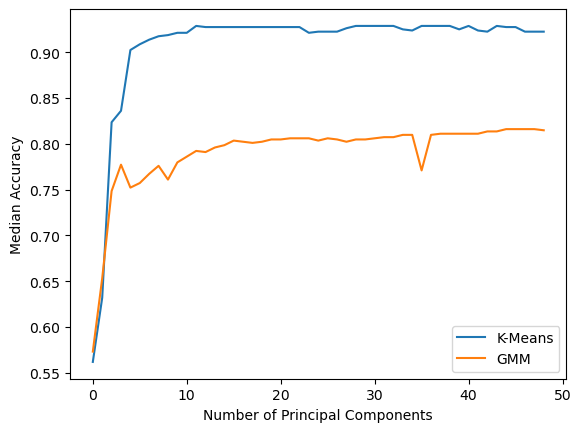

In [777]:
# #Execution time of kmeans and GMM using 1 to 50 components

plt.plot(range(len(med_acc)), med_acc)
plt.plot(range(len(gmm_med_acc)), gmm_med_acc)
plt.xlabel('Number of Principal Components')
plt.ylabel('Median Accuracy')
plt.legend(['K-Means', 'GMM'])

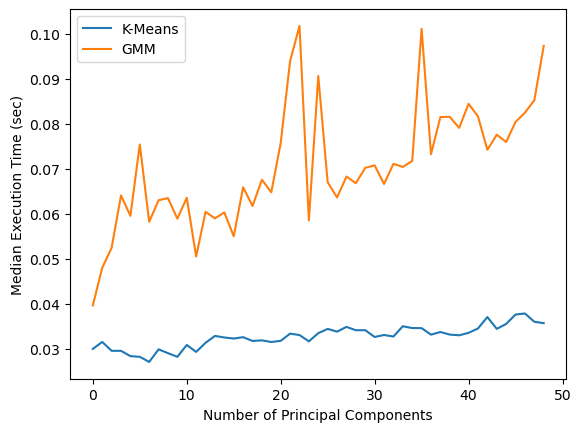

In [778]:
#Execution time of kmeans and GMM using 1 to 50 components
plt.plot(range(len(med_timer)), med_timer)
plt.plot(range(len(gmm_med_timer)), gmm_med_timer)
plt.xlabel('Number of Principal Components')
plt.ylabel('Median Execution Time (sec)')
plt.legend(['K-Means', 'GMM'])

Interestingly, GMM uses a lot of computing power for lackluster results compared to the kmeans algorithm.
Maybe the approach is far more data hungry than kmeans. Let's try to increase how many features we run it with to 500 components.

In [779]:
# Recalculate the PCA with 500 components
df['Class'] = sample_class
n_components = 500
pca = PCA(n_components=n_components)
PC = pca.fit_transform(features)
df_pca = pd.DataFrame(data = PC,
    columns = [f'PC{i}' for i in range(1,n_components+1)])
df_pca = pd.concat([df_pca, df[['Class']]], axis = 1)

#gmm
timer, acc = [[] for _ in range(500)], [[] for _ in range(500)]

for _ in range(10):
    for i in range(50, 500, 25):
        df_tmp = df_pca.iloc[:, :i].copy()
        df_tmp['Class'] = df_pca['Class']
        start = time()
        df_tmp = compute_gmm(df_tmp, n_clusters)
        end = time()

        # Assigning the most frequent class to each cluster
        for k in range(n_clusters):
            labels = df_tmp[['group', 'Class']]
            labels = labels[labels['group'] == k]
            label = labels['Class'].value_counts().index[0]
            df_tmp.loc[df_tmp['group'] == k, 'pred_class'] = label

        run_time = end - start
        conf_mat =  confusion_matrix(df_tmp["Class"], df_tmp["pred_class"])
        timer[i].append(run_time)
        acc[i].append(accuracy_score(df_tmp["Class"], df_tmp["pred_class"]))
        df_tmp.drop(['group', 'pred_class'], axis=1, inplace=True)

gmm_med_timer_500, gmm_med_acc_500 = [], []
for i in range(0,len(timer)):
    try:
        gmm_med_timer_500.append(statistics.median(timer[i]))
        gmm_med_acc_500.append(statistics.median(acc[i]))
    except:
        continue

#Kmeans
timer, acc = [[] for _ in range(500)], [[] for _ in range(500)]

for _ in range(10):
    for i in range(50, 500, 25):
        temp_df = df_pca.iloc[:, :i].copy()
        temp_df['Class'] = df_pca['Class']
        start = time()
        temp_df = compute_kmeans(temp_df, n_clusters)
        end = time()
        run_time = end - start
        conf_mat =  confusion_matrix(temp_df["Class"], temp_df["pred_class"])
        accuracy_score(temp_df["Class"], temp_df["pred_class"])
        timer[i].append(run_time)
        acc[i].append(accuracy_score(temp_df["Class"], temp_df["pred_class"]))
med_timer_500, med_acc_500 = [], []
for i in range(0,len(timer)):
    try:
        med_timer_500.append(statistics.median(timer[i]))
        med_acc_500.append(statistics.median(acc[i]))
    except:
        continue

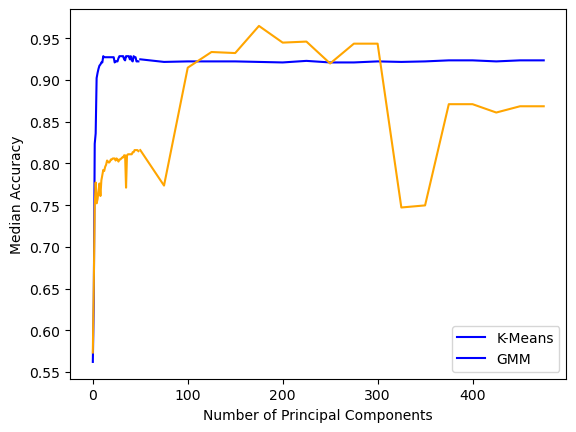

In [780]:
# Overview of kmeans vs. gmm Accuracy depending on the number of principal components.

plt.plot(range(len(med_acc)), med_acc, c='blue')
plt.plot(range(50, 500, 25), med_acc_500, c='blue')

plt.plot(range(len(gmm_med_acc)), gmm_med_acc, c='orange')
plt.plot(range(50, 500, 25), gmm_med_acc_500, c='orange')

plt.xlabel('Number of Principal Components')
plt.ylabel('Median Accuracy')
plt.legend(['K-Means', 'GMM'])

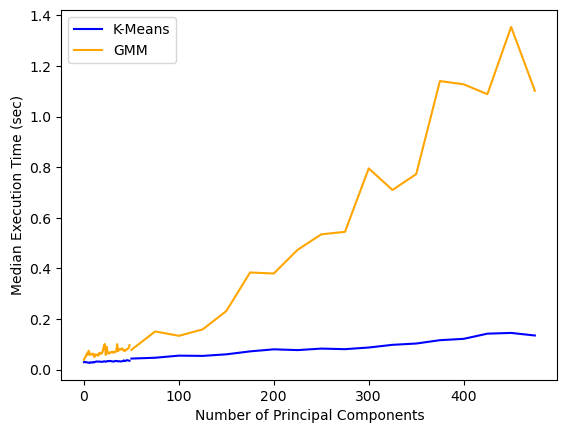

In [781]:
# Overview of kmeans vs. gmm execution time depending on the number of principal components.
plt.plot(range(len(med_timer)), med_timer, c='blue')
plt.plot(range(len(gmm_med_timer)), gmm_med_timer, c='orange')
plt.plot(range(50, 500, 25), med_timer_500, c='blue')
plt.plot(range(50, 500, 25), gmm_med_timer_500, c='orange')
plt.xlabel('Number of Principal Components')
plt.ylabel('Median Execution Time (sec)')
plt.legend(['K-Means', 'GMM'])

Indeed it would seem that GMM needs more data to get a good classification out of it, while kmeans needs way less. \
While the computation time required makes it hard to get data points for high numbers of PCs and the curves are not completely accurate, it seems that PCA has plateaued as about 0.
95 accuracy while GMM sometimes reaches higher accuracy values, but requires lots of computing time and a high number of features. 
These results highlights the importance of choosing a method adaptated to the dataset.

## Multi Dimensional Scaling
Clusterization methods aren't the only things that can be tweaked when playing around with clustering. \
Since the dimensionnaly reduced features serve as a basis, it should also be factored in.

In [782]:
# Compute MDS with 25 components

from sklearn.metrics import pairwise_distances
from sklearn import manifold

n_components = 25
features = df_values # df_values is the raw number dataframe without the labels ie. all features.
features = StandardScaler().fit_transform(features)
labels = df['Class'].values
mds = manifold.MDS(n_components=n_components, n_init=10, random_state=1)
Xmds = mds.fit_transform(features)
df_mds = pd.DataFrame(data = Xmds,
    columns = [f'MDS{i}' for i in range(1, n_components+1)])
df_mds = pd.concat([df_mds, df[['Class']]], axis = 1)
df_mds

,MDS1,MDS2,MDS3,MDS4,MDS5,MDS6,MDS7,MDS8,MDS9,MDS10,...,MDS17,MDS18,MDS19,MDS20,MDS21,MDS22,MDS23,MDS24,MDS25,Class
0,-59.022457,18.298179,-58.643638,-37.794321,-2.092201,12.797334,-33.101017,42.497587,7.802727,25.990752,...,3.459413,6.956673,21.731653,-50.910244,-21.403540,19.728411,-47.422280,40.155755,8.290671,PRAD
1,23.289311,-28.063606,18.092517,51.640193,41.136897,37.446476,-14.873040,9.540767,-24.497590,-11.915909,...,-4.104889,16.731322,-0.920771,-14.861690,-9.282272,-54.841223,1.012677,-53.471665,-31.553424,LUAD
2,-42.248732,-40.544800,-11.555977,25.420289,69.824789,0.261343,-40.168933,-16.083937,33.216415,-14.483058,...,-47.130199,-36.011365,-79.278071,-38.559129,-30.146841,-35.263239,45.441712,-7.332100,-1.081973,PRAD
3,-49.592634,21.834244,-15.984170,-31.372671,5.370181,-42.527182,-45.649030,5.640899,13.291981,35.312805,...,-26.207209,-21.538317,-40.525919,-4.908322,1.848599,-12.183375,-2.535147,22.706831,-36.745966,PRAD
4,-9.970092,11.372503,5.303995,26.968011,34.399028,-10.940585,-10.596785,2.939467,2.761108,23.087495,...,-8.029754,33.211213,42.945565,-5.513906,-30.620494,28.313758,-5.778378,-4.662782,28.611569,BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,4.732737,-6.491278,-5.704364,17.307793,13.465078,-44.212046,-24.520616,-1.709319,7.157638,-1.793527,...,0.978067,65.930306,47.912002,-8.435413,-22.004562,20.754126,18.401446,28.117828,23.654439,BRCA
795,-32.750828,29.872738,9.336764,-40.965554,-18.805301,-12.852661,7.412774,36.294265,45.549544,-23.038206,...,9.292163,39.486901,-0.443772,29.051950,-2.910972,-52.404913,-6.448926,-44.265593,31.819257,LUAD
796,-45.728149,20.113605,22.729035,74.751442,-49.460578,92.167470,29.381978,-28.602222,27.087213,-37.144425,...,-22.695127,-47.968922,35.386731,21.107230,-4.010831,32.232629,29.131160,-89.079140,49.713634,COAD
797,-3.200490,45.388168,-10.081486,40.814705,14.466989,28.502790,-39.553899,45.288586,31.160323,-12.693203,...,-26.014853,-63.413926,3.531080,9.662843,33.705602,34.997571,-2.755114,25.975580,39.447458,PRAD


We will stick with 12 components for now, as we are trying to compare MDS components to PCA components and not two clusterization methods.

In [783]:
# Computing GMM clusters using MDS components.
timer, acc = [[] for _ in range(25)], [[] for _ in range(25)]
for _ in range(25):
    for i in range(1, 25):
        df_tmp = df_mds.iloc[:, :i].copy()
        df_tmp['Class'] = df_mds['Class']
        start = time()
        df_tmp = compute_gmm(df_tmp, n_clusters)
        end = time()

        # Assigning the most frequent class to each cluster
        for k in range(n_clusters):
            labels = df_tmp[['group', 'Class']]
            labels = labels[labels['group'] == k]
            label = labels['Class'].value_counts().index[0]
            df_tmp.loc[df_tmp['group'] == k, 'pred_class'] = label

        run_time = end - start
        conf_mat =  confusion_matrix(df_tmp["Class"], df_tmp["pred_class"])
        timer[i].append(run_time)
        acc[i].append(accuracy_score(df_tmp["Class"], df_tmp["pred_class"]))
        df_tmp.drop(['group', 'pred_class'], axis=1, inplace=True)

mds_gmm_med_timer, mds_gmm_med_acc = [], []
for i in range(0,len(timer)):
    try:
        mds_gmm_med_timer.append(statistics.median(timer[i]))
        mds_gmm_med_acc.append(statistics.median(acc[i]))
    except:
        continue

In [ ]:
# Computing kmeans clusters using MDS components.
timer, acc = [[] for _ in range(25)], [[] for _ in range(25)]

for _ in range(25):
    for i in range(1, 25):
        temp_df = df_mds.iloc[:, :i].copy()
        temp_df['Class'] = df_mds['Class']
        start = time()
        temp_df = compute_kmeans(temp_df, n_clusters)
        end = time()
        run_time = end - start
        conf_mat =  confusion_matrix(temp_df["Class"], temp_df["pred_class"])
        accuracy_score(temp_df["Class"], temp_df["pred_class"])
        timer[i].append(run_time)
        acc[i].append(accuracy_score(temp_df["Class"], temp_df["pred_class"]))
mds_med_timer, mds_med_acc = [], []
for i in range(0,len(timer)):
    try:
        mds_med_timer.append(statistics.median(timer[i]))
        mds_med_acc.append(statistics.median(acc[i]))
    except:
        continue

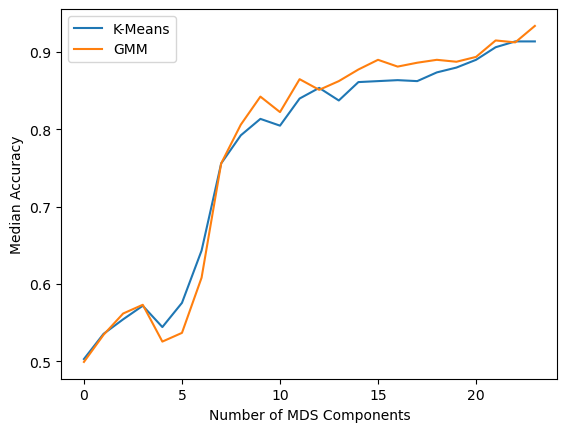

In [ ]:
# Plotting Accuracy vs.number of MDS Components
plt.plot(range(len(mds_med_acc)), mds_med_acc)
plt.plot(range(len(mds_gmm_med_acc)), mds_gmm_med_acc)
plt.xlabel('Number of MDS Components')
plt.ylabel('Median Accuracy')
plt.legend(['K-Means', 'GMM'])

By using MDS components, both the k-means and GMM methods seem to scale similarly in terms of accuracy (at least with n=25 components).


## Conclusion

How does one approach a clusterisation problem ? 
* Consider the number of features available. Numerous features may require feature engineering through dimension reduction in order to make the dataset smaller while keeping as much information as possible.
* Try different methods. Whether it be dimension reduction methods or clusterisation methods, one can't really know which one will have the best performance (altough it's sometimes possible to guess from the shape of the data).